In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [ ]:
#initialize the parameters randomly
def param_init(dim_layer):
    np.random.seed(1)
    params = {}
    length = len(dim_layer)            
    for i in range(1, length):
        params['W' + str(i)] = np.random.randn(dim_layer[i], dim_layer[i-1]) / np.sqrt(dim_layer[i-1]) #*0.01
        params['b' + str(i)] = np.zeros((dim_layer[i], 1))
    return params

In [ ]:
#sigmoid activation function
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    prev = z
    return a, prev

In [ ]:
#rectified linear activation function
def relu(z):
    a = np.maximum(0,z)
    prev = z 
    return a, prev

In [ ]:
#essentially y=mx+c
def forward(a, W, b):
    z = W.dot(a) + b
    #store prev values because we will need it for backprop
    prev = (a, W, b)
    return z, prev

In [ ]:
#after y=mx+c, we need to pass it through activation fn. a = activation_function(y)
def forward_prop_activation(a_prev, W, b, act_fn):
    if act_fn == "sigmoid":
        z, prev_linear = forward(a_prev, W, b)
        a, prev_activation = sigmoid(z)
    elif act_fn == "relu":
        z, prev_linear = forward(a_prev, W, b)
        a, prev_activation = relu(z)
    #store the prev values because we will need it for backprop
    prev = (prev_linear, prev_activation)
    return a, prev

In [ ]:
#start feed forward. 1st to 2nd last layer is relu and last layer is sigmoid
def forward_prop(X, params):
    prevs = []
    a = X
    length = len(params) // 2 
    for i in range(1, length):
        a_prev = a 
        a, prev = forward_prop_activation(a_prev, params['W' + str(i)], params['b' + str(i)], act_fn = "relu")
        prevs.append(prev)
    yhat, prev = forward_prop_activation(a, params['W' + str(length)], params['b' + str(length)], act_fn = "sigmoid")
    prevs.append(prev)
    return yhat, prevs

In [ ]:
#calculate cross entropy loss or mean square loss
def error_calc(yhat, y):
    m = y.shape[1]
    #error = (np.sum((y-yhat)**2))/m #mean sqaure error
    error = (1./m) * (-np.dot(y,np.log(yhat).T) - np.dot(1-y, np.log(1-yhat).T)) #cross entropy error
    error = np.squeeze(error)      # [[X]] into X).
    return error

In [ ]:
#backprop for sigmoid activation fn
def back_prop_sigmoid(da, prev):
    z = prev
    s = 1/(1+np.exp(-z))
    dz = da*s*(1-s)
    return dz

In [ ]:
#backprop for relu activation fn
def back_prop_relu(da, prev):
    z = prev
    dz = np.array(da, copy=True)
    dz[z<=0]=0
    return dz

In [ ]:
#backprop for the linear eq
def back(dz, prev):
    a_prev, W, b = prev
    m = a_prev.shape[1]
    dW = np.dot(dz,a_prev.T)/m
    db = np.sum(dz, axis = 1, keepdims = True)/m
    da_prev = np.dot(W.T,dz)
    return da_prev, dW, db

In [ ]:
#backpop for the activation fn and linear combined
def back_prop_activation(da, prev, act_fn):
    prev_linear, prev_activation = prev
    
    if act_fn == "relu":
        dz = back_prop_relu(da, prev_activation)
        da_prev, dW, db = back(dz, prev_linear)
        
    elif act_fn == "sigmoid":
        dz = back_prop_sigmoid(da, prev_activation)
        da_prev, dW, db = back(dz, prev_linear)
    
    return da_prev, dW, db

In [ ]:
#main backprop function
def back_prop(yhat, Y, prevs):
    gradients = {}
    length = len(prevs) 
    m = yhat.shape[1]
    Y = Y.reshape(yhat.shape)
    
    dyhat = - (np.divide(Y, yhat) - np.divide(1 - Y, 1 - yhat))
    
    latest_prev = prevs[length-1]
    gradients["da" + str(length-1)], gradients["dW" + str(length)], gradients["db" + str(length)] = back_prop_activation(dyhat, latest_prev, act_fn = "sigmoid")
    
    for i in reversed(range(length-1)):
        latest_prev = prevs[i]
        da_prev_temp, dW_temp, db_temp = back_prop_activation(gradients["da" + str(i + 1)], latest_prev, act_fn = "relu")
        gradients["da" + str(i)] = da_prev_temp
        gradients["dW" + str(i + 1)] = dW_temp
        gradients["db" + str(i + 1)] = db_temp

    return gradients

In [ ]:
#update weights using W = W - alpha*dW
def weight_update(params, gradients, alpha_lr):
    length = len(params) // 2 
    for i in range(length):
        params["W" + str(i+1)] = params["W" + str(i+1)] - alpha_lr * gradients["dW" + str(i+1)]
        params["b" + str(i+1)] = params["b" + str(i+1)] - alpha_lr * gradients["db" + str(i+1)]       
    return params

In [ ]:
#function to load the data
def load_data():
    training_data = h5py.File('/content/train_catvnoncat.h5', "r")
    train_x_orig = np.array(training_data["train_set_x"][:])
    train_y_orig = np.array(training_data["train_set_y"][:])

    testing_data = h5py.File('/content/test_catvnoncat.h5', "r")
    test_x_orig = np.array(testing_data["test_set_x"][:])
    test_y_orig = np.array(testing_data["test_set_y"][:])

    classes = np.array(testing_data["list_classes"][:])
    
    train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
    test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [ ]:
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [ ]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T 
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize so feature values are b/w 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [ ]:
def model_train(X, Y, dim_layers, alpha_lr = 0.0075, epochs = 3000):#lr was 0.009
    np.random.seed(1)
    errors = [] 
    params = param_init(dim_layers)
    for epoch_no in range(0, epochs):
        #feed forward
        yhat, caches = forward_prop(X, params)
        #error calc
        error = error_calc(yhat, Y)
        #backprop
        gradients = back_prop(yhat, Y, caches)
        #weight update
        params = weight_update(params, gradients, alpha_lr)
                
        if epoch_no%100 == 0:
          print("Error at epoch number " + str(epoch_no) + " is " + str(error))
          errors.append(error)
            
    plt.plot(np.squeeze(errors))
    plt.ylabel('error')
    plt.xlabel('epochs (per hundreds)')
    plt.title('using cross entropy error')
    plt.show()
    
    return params

In [ ]:
#Enter hyperparameters here 
#Number of layers = number of elements
#Number of nodes in each layer = value of each element
dim_layers = [12288, 30, 20, 7, 5, 1]
alpha_lr = 0.0075
epochs = 2000

Error at epoch number 0 is 0.2506965137559553
Error at epoch number 100 is 0.20633487543734239
Error at epoch number 200 is 0.16108607980772183
Error at epoch number 300 is 0.1310465769555118
Error at epoch number 400 is 0.10189102303087076
Error at epoch number 500 is 0.11656283542944157
Error at epoch number 600 is 0.030433559653676955
Error at epoch number 700 is 0.010623439291159269
Error at epoch number 800 is 0.0064701302693270036
Error at epoch number 900 is 0.00498456885341758
Error at epoch number 1000 is 0.004439361040831979
Error at epoch number 1100 is 0.0041542898823279635
Error at epoch number 1200 is 0.00398462357925726
Error at epoch number 1300 is 0.003878653834447156
Error at epoch number 1400 is 0.003804001765450779
Error at epoch number 1500 is 0.003748766585222687
Error at epoch number 1600 is 0.003704762861227517
Error at epoch number 1700 is 0.0036667334055574736
Error at epoch number 1800 is 0.0036351506048975355
Error at epoch number 1900 is 0.00360597035873593

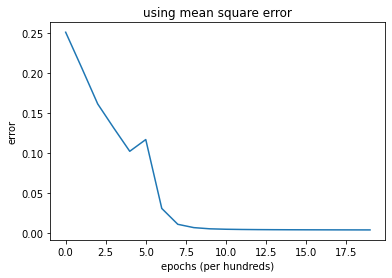

In [ ]:
params = model_train(train_x, train_y, dim_layers, alpha_lr, epochs)

Error at epoch number 0 is 0.6945407266458821
Error at epoch number 100 is 0.6023791979317227
Error at epoch number 200 is 0.493691308443186
Error at epoch number 300 is 0.40897379786727944
Error at epoch number 400 is 0.32500436871879385
Error at epoch number 500 is 0.3546172707015601
Error at epoch number 600 is 0.1234134379393858
Error at epoch number 700 is 0.06137048818200425
Error at epoch number 800 is 0.0401848482649078
Error at epoch number 900 is 0.029938839824625144
Error at epoch number 1000 is 0.02454600194490176
Error at epoch number 1100 is 0.021073449121849882
Error at epoch number 1200 is 0.018835804471884023
Error at epoch number 1300 is 0.017259521542887707
Error at epoch number 1400 is 0.016074754559685656
Error at epoch number 1500 is 0.01517674228454926
Error at epoch number 1600 is 0.014484536228562063
Error at epoch number 1700 is 0.013895166077046108
Error at epoch number 1800 is 0.013451218269776832
Error at epoch number 1900 is 0.013052738777412462


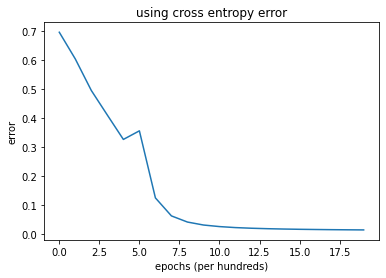

In [ ]:
params = model_train(train_x, train_y, dim_layers, epochs = 2000)